In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import gsw
from pyproj import Geod

# Load local modules
import hakai
import utils
from qc.hakai_ctd_profile import get_hakai_ctd_profile_parameters 

In [3]:
# Get External packages
try:
    from hakai_api import Client
    from ioos_qc.config import QcConfig
except:
    # Install Hakai API Python Client
    !pip install git+https://github.com/HakaiInstitute/hakai-api-client-python.git
    from hakai_api import Client

    # Install ioos_qc
    !pip install git+https://github.com/ioos/ioos_qc.git
    from ioos_qc.config import QcConfig

In [4]:
def get_hakai_ctd_data(filterUrl):
    # Get Hakai Data    
    #Get Data from Hakai API
    client = Client() # Follow stdout prompts to get an API token
    
    # CTD data endpoint
    hakai_ctd_endpoint = 'ctd/views/file/cast/data'
    
    # Make a data request for sampling stations
    url = '%s/%s?%s' % (client.api_root,hakai_ctd_endpoint,filterUrl)
    response = client.get(url)
    df = pd.DataFrame(response.json())
    return df,url


In [5]:
# Load Hakai Station List
hakai_stations = hakai.get_hakai_stations()

In [6]:
# Get Hakai CTD Data Download through the API
def get_hakai_ctd_data(filterUrl):
    # Get Hakai Data    
    #Get Data from Hakai API
    client = Client() # Follow stdout prompts to get an API token
    
    # CTD data endpoint
    hakai_ctd_endpoint = 'ctd/views/file/cast/data'
    
    # Make a data request for sampling stations
    url = '%s/%s?%s' % (client.api_root,hakai_ctd_endpoint,filterUrl)
    response = client.get(url)
    df = pd.DataFrame(response.json())
    return df,url

# Just get 
filterUrl = 'station=QU39&status!=MISCAST&limit=20000'
df, url = get_hakai_ctd_data(filterUrl)
print(str(len(df))+' records found')

# Regroup profiles and sort them by pressure
group_variables = ['device_model','device_sn','ctd_file_pk','ctd_cast_pk','direction_flag']
df = df.sort_values(by=group_variables+['pressure'])

# Get Derived Variables
df = utils.get_ocean_derived_variables(df)

df.head() # Show the top of the data frame

20000 records found


C:\Users\jessy\Anaconda3\lib\site-packages\gsw\_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


,ctd_file_pk,ctd_cast_pk,hakai_id,ctd_data_pk,filename,device_model,device_sn,device_firmware,file_processing_stage,work_area,...,cast_type,sensors_submerged,water_depth_m,soak_start,soak_end,weather,absolute salinity,conservative temperature,density,sigma0
0,2183,7202,080217_2016-03-07T17:23:34.333Z,9475691,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.883805,8.406325,1020.776815,20.772209
1,2183,7202,080217_2016-03-07T17:23:34.333Z,9475692,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.879740,8.414078,1020.777237,20.768025
2,2183,7202,080217_2016-03-07T17:23:34.333Z,9475693,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.881705,8.414060,1020.783372,20.769554
3,2183,7202,080217_2016-03-07T17:23:34.333Z,9475694,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.883166,8.414554,1020.789049,20.770624
4,2183,7202,080217_2016-03-07T17:23:34.333Z,9475695,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.885130,8.414434,1020.795197,20.772167


In [7]:
# Load default test parameters used right now!
qc_config = get_hakai_ctd_profile_parameters()


In [12]:
# If you want to add or modify some of the tests do it here
#ex: let's add for the range of fluorescence 
qc_config['flc']= {'qartod': {
                        'gross_range_test': {   
                            "suspect_span": [0, 70],
                            "fail_span": [-.5, 100],
                        },
    
                        "aggregate": {}    
                        }
                   }


In [9]:
# Run all the tests on each available profiles
df_out = hakai.run_tests_on_profiles(df,hakai_stations,qc_config)

QA QC QU39
position
{'qartod': {'location_test': {'bbox': [-125.14107014641213, 50.00372871260039, -125.05732985358786, 50.05767116137374], 'range': 3000}, 'aggregate': {}}}
pressure
{'qartod': {'gross_range_test': {'suspect_span': [0, 280.83826311944904], 'fail_span': [0, 294.2115137441847], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1}, 'aggregate': {}}}
depth
{'qartod': {'gross_range_test': {'suspect_span': [0, 278.25], 'fail_span': [0, 291.5], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1}, 'aggregate': {}}}
dissolved_oxygen_ml_l
{'qartod': {'gross_range_test': {'fail_span': [0, 12], 'suspect_span': [1, 10]}, 'rate_of_change_test': {'threshold': 1}, 'spike_test': {'suspect_threshold': 0.5, 'fail_threshold': 1}, 'attenuated_signal_test': {'suspect_threshold': 0.5, 'fail_threshold': 0.2, 'check_type': 'range'}, 'aggregate': {}}}
rinko_do_ml_l
{'qartod': {'gross_range_test': {'fail_span': [0, 12], 'suspect_span': [1, 10]}, 'rate_of_change

7202
106
750
761
881
896
948
977
1017
1063
1076
1073
11825
12113
12129
99
124
212
323
326
372
393
7702


C:\Users\jessy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


444
446
459
506
508
519
581
625
642
663
7896
7703
7707
9017
9289
9608
9867
9886
9976
9977
10035
10082
10317
10321
10328
10392
10547
10564
10659
11055
11433
11446
11553
12791
12946
13064
13127
13400
12485
12574
12629
12674
12740


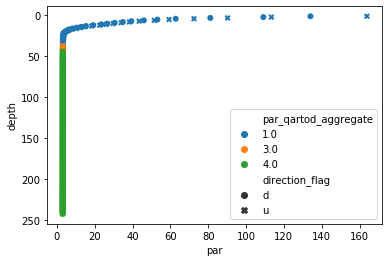

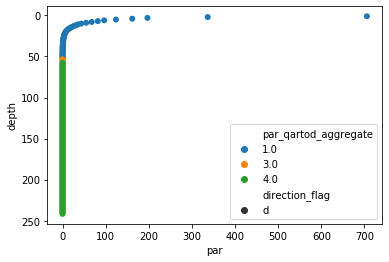

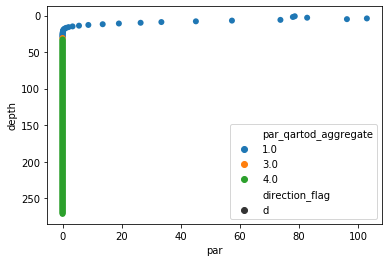

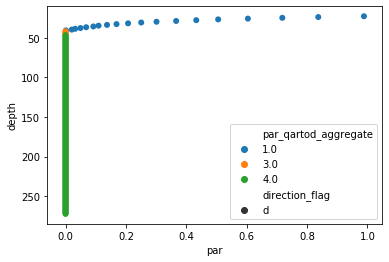

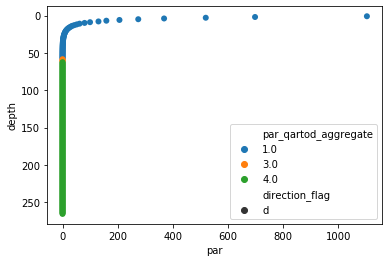

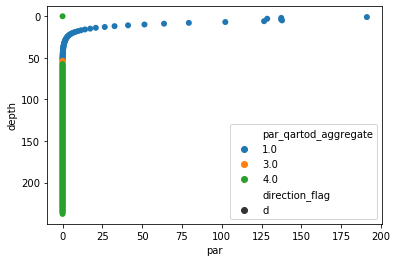

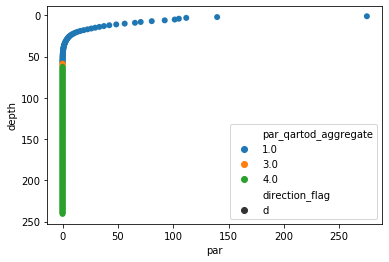

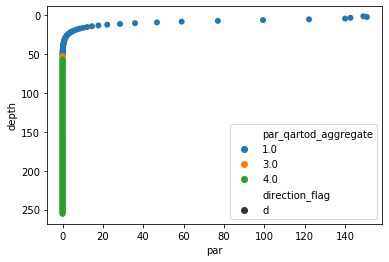

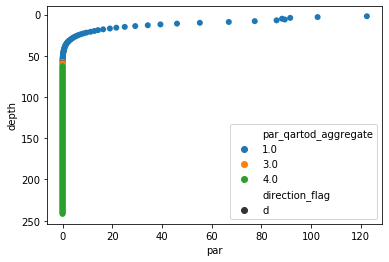

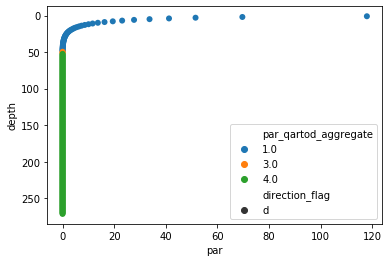

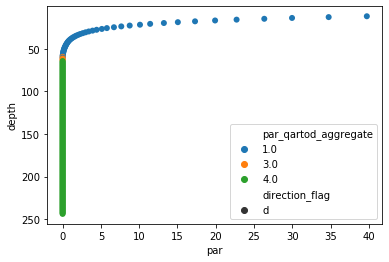

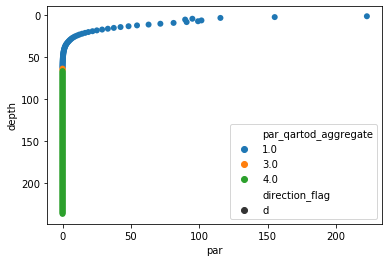

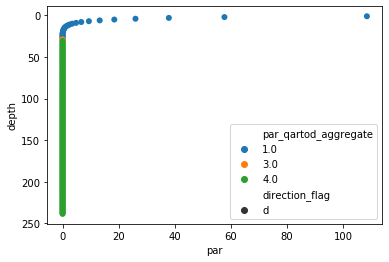

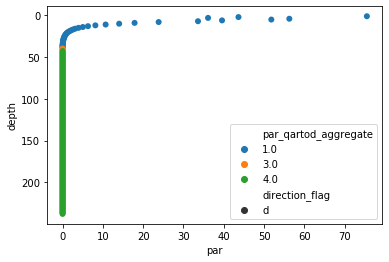

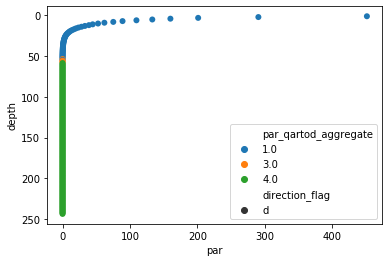

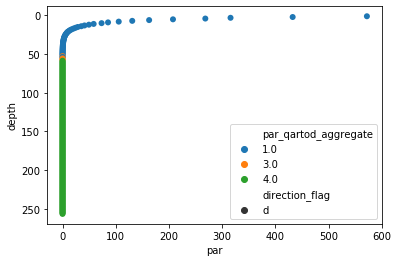

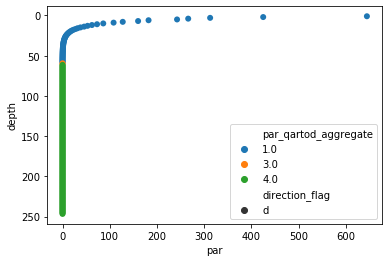

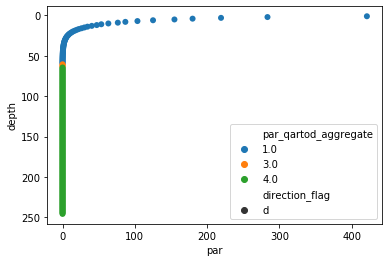

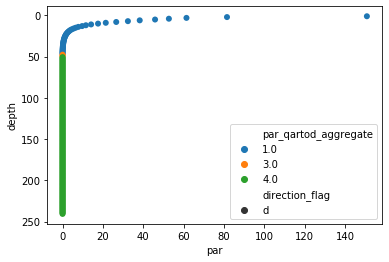

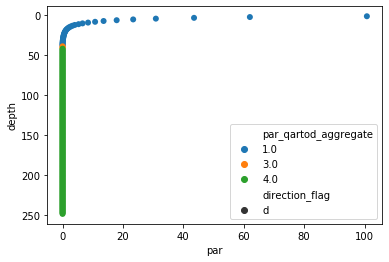

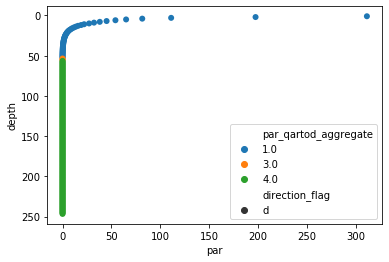

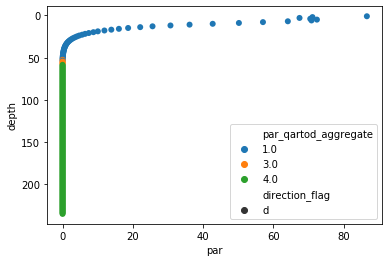

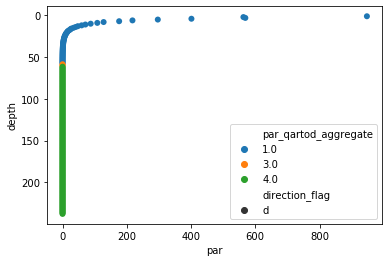

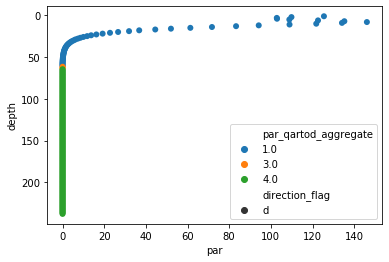

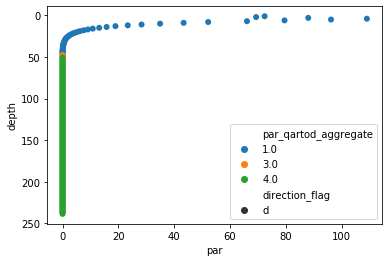

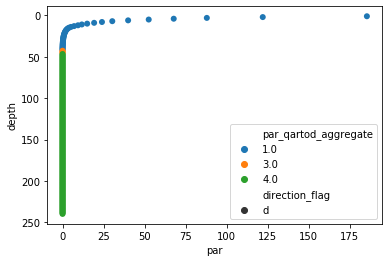

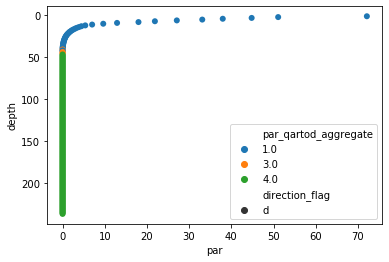

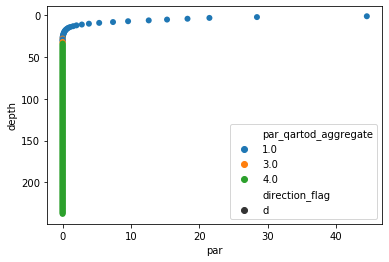

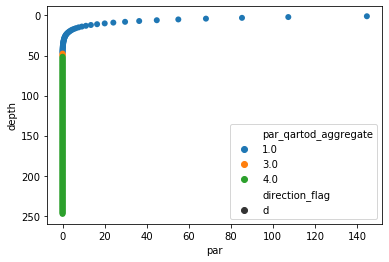

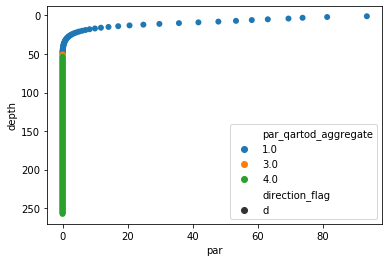

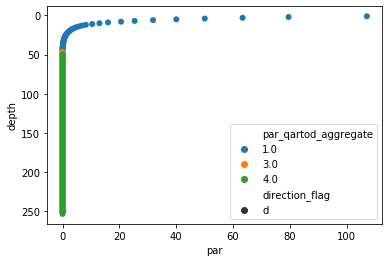

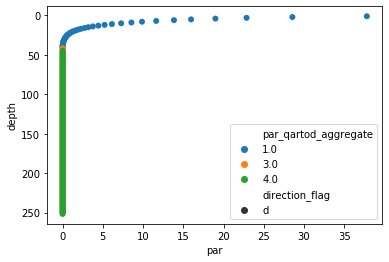

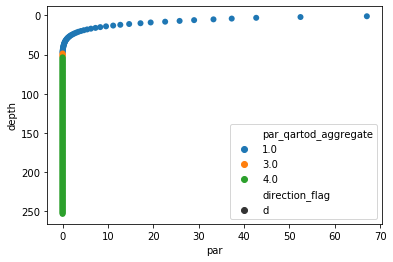

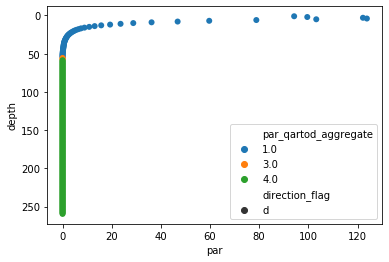

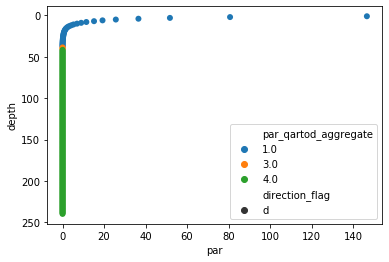

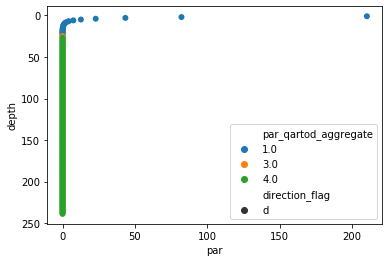

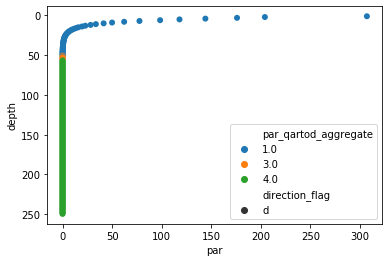

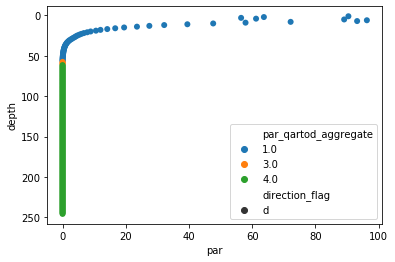

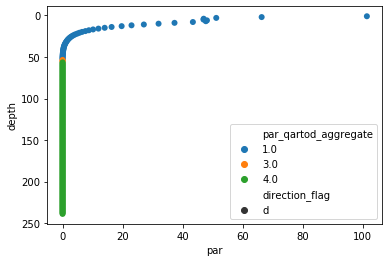

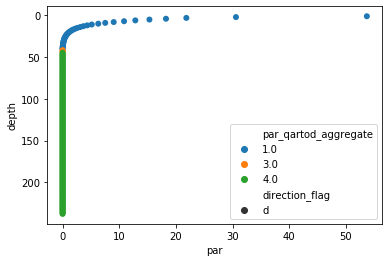

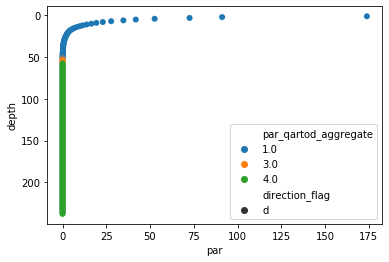

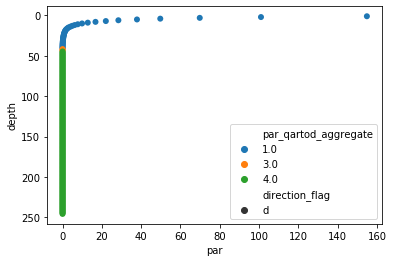

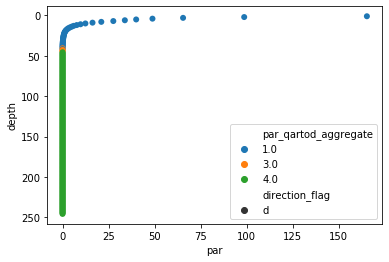

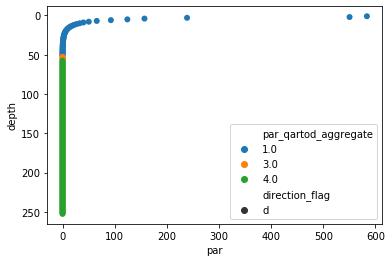

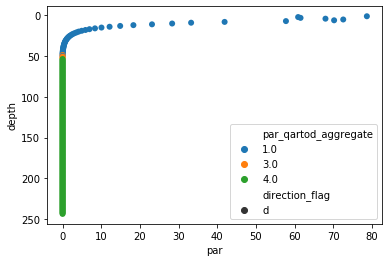

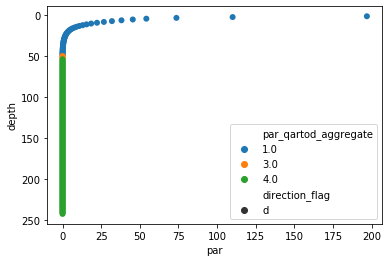

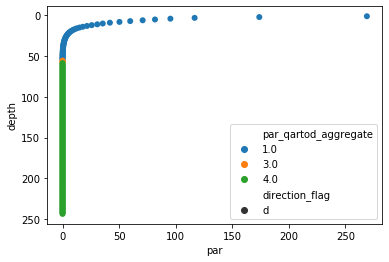

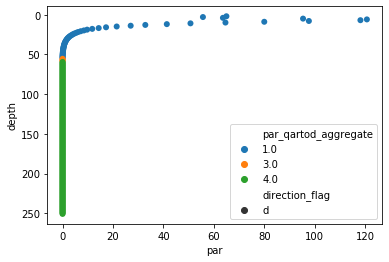

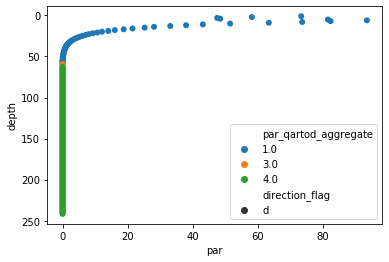

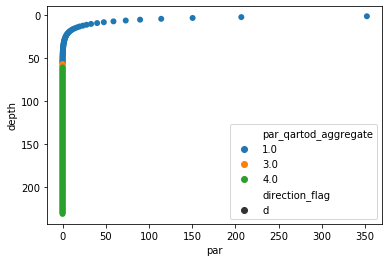

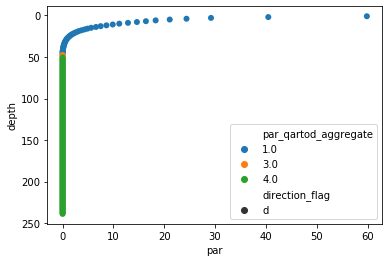

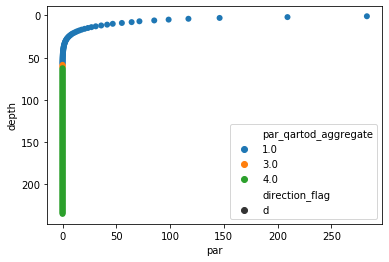

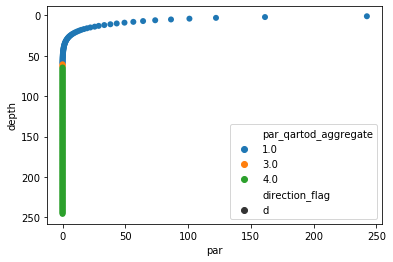

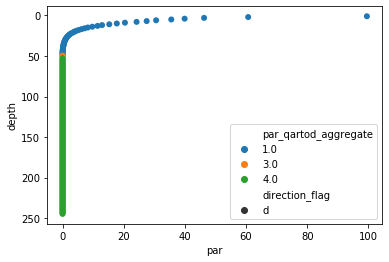

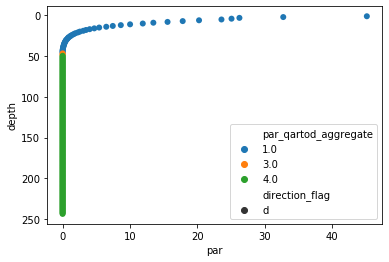

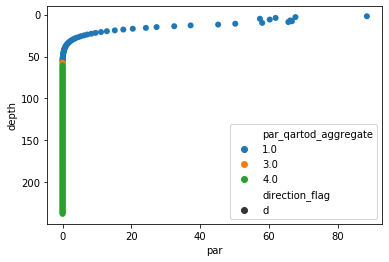

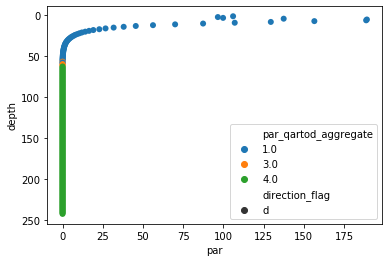

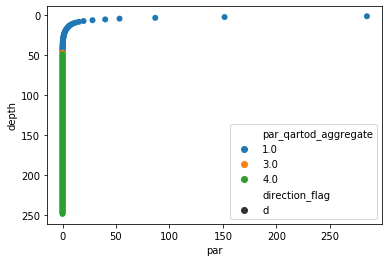

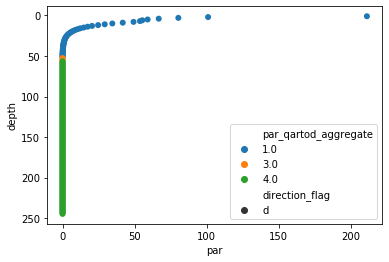

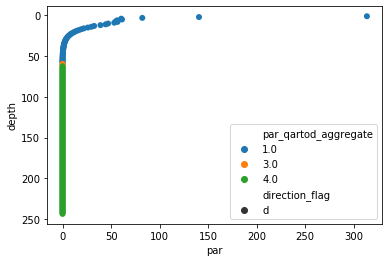

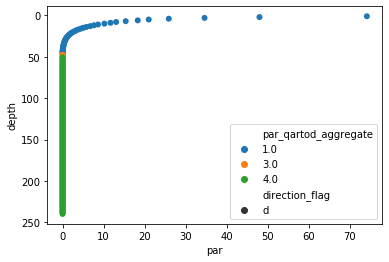

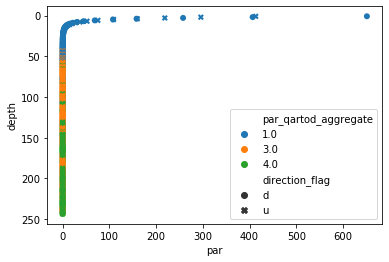

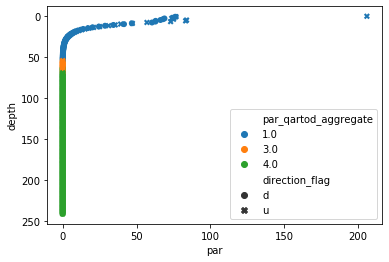

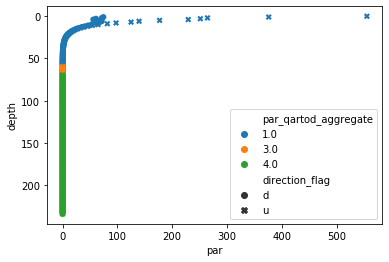

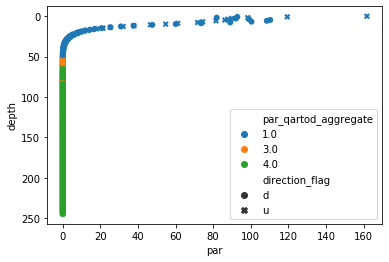

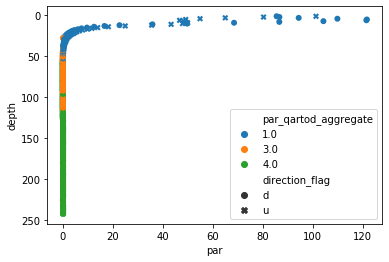

In [11]:
# Review Flagged data
var = "par"
flagged_df = df[(df[var+'_qartod_aggregate']>1) & 
                (df[var+'_qartod_aggregate']!=9) &
                (df['direction_flag']=='d')]

for pk in flagged_df['ctd_cast_pk'].unique():
    print(str(pk))
    plt.figure()
    # Plot Data
    ax = sns.scatterplot(data=df[df['ctd_cast_pk']==pk],
                         x=var,y='depth',
                         hue=var+'_qartod_aggregate', palette='tab10',
                         style='direction_flag',
                         linewidth=0)
    ax.invert_yaxis()
